In [17]:
import os
import json
import yaml
import re
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

We'll separate objects into two categories:



| **Type**            | **Examples**             | **Behavior**                      | **Where Stored**                                 |
| ------------------- | ------------------------ | --------------------------------- | ------------------------------------------------ |
| **Static objects**  | bench, chair, swing, slide | stay fixed relative to the camera | configs/objects.yaml (camera-wise)               |
| **Dynamic objects** | dog, sports ball      | move per frame                    | remain in merged JSON → become part of .npy data |

In [3]:
merged_dir = "./../../data/temp/merged/"
output_yaml = "./../../config/objects.yaml"
os.makedirs(os.path.dirname(output_yaml), exist_ok=True)

In [4]:
STATIC_CLASSES = ["bench", "skateboard", "bicycle", "chair"]
DYNAMIC_CLASSES = ["dog", "sports ball", "tennis racket", "frisbee"]

In [11]:
frame_w = 2560
frame_h = 1440
camera_objects = {}

In [12]:
def extract_camera_name(filename: str) -> str:
    base = os.path.basename(filename)
    match = re.search(r'(hundidocam\d+|columpios[_]?cam\d+|columpios_tierra)', base)
    if match:
        return match.group(1)
    else:
        return "unknown_camera"

In [13]:
for file in os.listdir(merged_dir):
    if not file.endswith("_merged.json"):
        continue

    cam_name = extract_camera_name(file)

    with open(os.path.join(merged_dir, file)) as f:
        data = json.load(f)

    centroids = {}
    for frame in data:
        for obj in frame.get("objects", []):
            cls = obj["class"].lower()
            if cls not in STATIC_CLASSES:
                continue
            cx, cy = obj["centroid"]
            cx /= frame_w
            cy /= frame_h
            centroids.setdefault(cls, []).append((cx, cy))

    if centroids:
        camera_objects[cam_name] = {
            "static_objects": {
                cls: [
                    float(np.mean([c[0] for c in coords])),
                    float(np.mean([c[1] for c in coords]))
                ]
                for cls, coords in centroids.items()
            }
        }

with open(output_yaml, "w") as f:
    yaml.dump(camera_objects, f, sort_keys=False)

print(f"Static object centroids saved to {output_yaml}")
print(f"Cameras processed: {list(camera_objects.keys())}")

Static object centroids saved to ./../../config/objects.yaml
Cameras processed: ['columpioscam1', 'columpioscam2', 'columpios_cam4', 'columpioscam3', 'columpios_tierra', 'hundidocam1', 'hundidocam2']


#### Find appropriate M = x for the tensor

In [16]:
max_people = 0
clip_stats = {}

for f in tqdm(os.listdir(merged_dir)):
    if not f.endswith("_merged.json"): continue
    with open(os.path.join(merged_dir, f)) as fp:
        frames = json.load(fp)
    max_in_clip = max(len(fr.get("people", [])) for fr in frames)
    clip_stats[f] = max_in_clip
    max_people = max(max_people, max_in_clip)

print(f"Max people across all clips: {max_people}")
print(f"Average per clip: {sum(clip_stats.values())/len(clip_stats):.2f}")

100%|██████████| 1147/1147 [00:00<00:00, 1335.03it/s]

Max people across all clips: 11
Average per clip: 1.40


100%|██████████| 1147/1147 [00:00<00:00, 1624.31it/s]


99th percentile: 5.00
Max: 11, Mean: 0.93


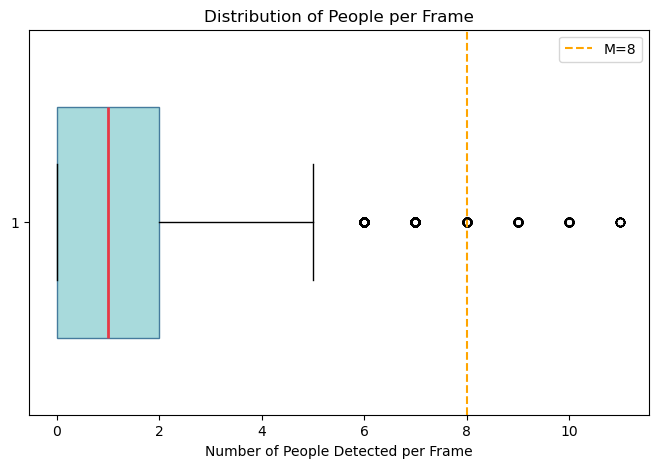

In [18]:
people_counts = []

for f in tqdm(os.listdir(merged_dir)):
    if not f.endswith("_merged.json"):
        continue
    with open(os.path.join(merged_dir, f)) as fp:
        frames = json.load(fp)
    counts = [len(fr.get("people", [])) for fr in frames]
    people_counts.extend(counts)

people_counts = np.array(people_counts)

p99 = np.percentile(people_counts, 99)
print(f"99th percentile: {p99:.2f}")
print(f"Max: {people_counts.max()}, Mean: {people_counts.mean():.2f}")

plt.figure(figsize=(8,5))
plt.boxplot(people_counts, vert=False, patch_artist=True, widths=0.6,
            boxprops=dict(facecolor="#a8dadc", color="#457b9d"),
            medianprops=dict(color="#e63946", linewidth=2))
plt.title("Distribution of People per Frame")
plt.xlabel("Number of People Detected per Frame")
plt.axvline(8, color='orange', linestyle='--', label='M=8')
plt.legend()
plt.show()

#### When could M = 6 hurt?

Only in the rare max (11-person) clips—if the 4 truly relevant people aren’t within the top-6 the selector keeps.

## Tensor Builder

In [22]:
objects_yaml = "./../../config/objects.yaml"
output_tensors = "./../../data/npy"
os.makedirs(output_tensors, exist_ok=True)

In [23]:
M = 6 # max people per clip
C = 3 # x, y, conf

DYNAMIC_CLASSES = ["dog", "sports ball", "tennis racket", "frisbee"]
CAM_PAT = re.compile(r'(hundidocam\d+|columpios[_]?cam\d+|columpios_tierra)')

In [24]:
def camera_name(path):
    m = CAM_PAT.search(os.path.basename(path))
    return m.group(1) if m else "unknown"

with open(objects_yaml) as f:
    static_cfg = yaml.safe_load(f)

In [25]:
def ensure_keypoints(kpts):
    arr = np.zeros((17, 3), np.float32)
    for i, kp in enumerate(kpts[:17]):
        arr[i] = [kp.get("x",0), kp.get("y",0), kp.get("conf",0)]
    return arr

In [26]:
def build_clip(json_path):
    cam = camera_name(json_path)
    static_objs = static_cfg.get(cam, {}).get("static_objects", {})
    S = len(static_objs)
    D = len(DYNAMIC_CLASSES)

    with open(json_path) as f:
        frames = json.load(f)
    T = len(frames)
    skel = np.zeros((T, M, 17, C), np.float32)
    objs = np.zeros((T, S + D, C), np.float32)

    track_map = {}
    next_slot = 0

    for t, fr in enumerate(frames):
        for p in fr.get("people", []):
            tid = p.get("track_id")
            if tid not in track_map and next_slot < M:
                track_map[tid] = next_slot; next_slot += 1
            if tid not in track_map: continue
            s = track_map[tid]
            k = ensure_keypoints(p["keypoints"])
            k[:,0] /= frame_w; k[:,1] /= frame_h
            skel[t, s] = k

        for j, cls in enumerate(DYNAMIC_CLASSES):
            dets = [o for o in fr.get("objects", []) if o["class"] == cls]
            if not dets: continue
            cx = np.mean([o["centroid"][0] for o in dets]) / frame_w
            cy = np.mean([o["centroid"][1] for o in dets]) / frame_h
            conf = np.mean([o["conf"] for o in dets])
            objs[t, j] = [cx, cy, conf]

        # --- static objects (same every frame) ---
        for k, (cls, (sx, sy)) in enumerate(static_objs.items()):
            objs[t, D + k] = [sx, sy, 1.0]

    return skel, objs

for f in tqdm(os.listdir(merged_dir)):
    if not f.endswith("_merged.json"): continue
    path = os.path.join(merged_dir, f)
    skel, objs = build_clip(path)
    np.save(os.path.join(output_tensors, f.replace("_merged.json", "_data.npy")), skel)
    np.save(os.path.join(output_tensors, f.replace("_merged.json", "_object_data.npy")), objs)

100%|██████████| 1147/1147 [00:01<00:00, 726.78it/s]


## Sanity Checks

In [28]:
pose_sample_path = "./../../data/npy/trimmed_columpios_cam4-2024-09-25_19_48_17_00-00-04_to_00-00-08_1438_data.npy"
obj_sample_path = "./../../data/npy/trimmed_columpios_cam4-2024-09-25_19_48_17_00-00-04_to_00-00-08_1438_object_data.npy"

pose = np.load(pose_sample_path)
objs = np.load(obj_sample_path)

print("Pose data shape:", pose.shape)
print("Object data shape:", objs.shape)

print("\nPose min/max:", pose.min(), pose.max())
print("Object min/max:", objs.min(), objs.max())

print("\nPose dtype:", pose.dtype, " Object dtype:", objs.dtype)

Pose data shape: (96, 6, 17, 3)
Object data shape: (96, 6, 3)

Pose min/max: 0.0 1.0
Object min/max: 0.0 1.0

Pose dtype: float32  Object dtype: float32


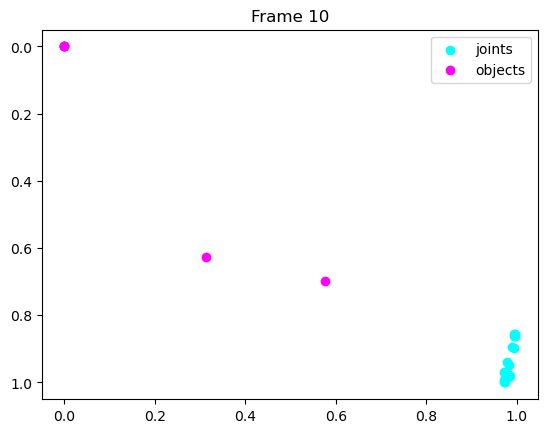

In [39]:
frame = 10
person = 0
import matplotlib.pyplot as plt

joints = pose[frame, person, :, :2]
plt.scatter(joints[:,0], joints[:,1], c='cyan', label='joints')
plt.scatter(objs[frame,:,0], objs[frame,:,1], c='magenta', label='objects')
plt.gca().invert_yaxis()
plt.legend()
plt.title(f"Frame {frame}")
plt.show()